# Project 2 Probabilistic Programming
## Olaru Bogdan-Ioan
## Grupa 407

In [0]:
%matplotlib inline
import pymc3 as pm
import theano.tensor as T
import tensorflow as tf
import theano
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from pymc3.theanof import set_tt_rng, MRG_RandomStreams

# Comparison on multiclass data classification

I will generate a dataset of 1000 samples with 3 classes represented by 3 blobs with different centers. 70% of dataset will be used as train data, and the rest of 30% will be used to test the models.

In [0]:
X, Y = make_blobs(n_samples=1000, centers=3, n_features=2,random_state=1)
X = scale(X)
X = X.astype('float64')
Y = Y.astype('float64')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3)

[Text(0, 0.5, 'Y'),
 Text(0.5, 0, 'X'),
 Text(0.5, 1.0, 'Multiclass classification dataset')]

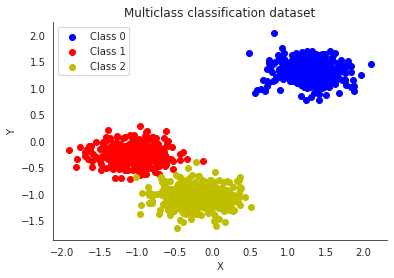

In [0]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], color='b', label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
ax.scatter(X[Y==2, 0], X[Y==2, 1], color='y', label='Class 2')
sns.despine()
ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Multiclass classification dataset')

## "Classic" neural networks model

I will implement an architecture with 2 hidden layer fully-connected layers, with 12 and with 6 neurons, using tanh as activation function and softmax for the output layer.

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(12, input_shape=(2,), activation='tanh'),
  tf.keras.layers.Dense(6, activation='tanh'),
  tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
%%time
model.fit(X_train, Y_train, epochs=5)
print(model.evaluate(X_test, Y_test))

Train on 700 samples
Epoch 1/5
700/700 [==============================] - 0s 334us/sample - loss: 1.4184 - acc: 0.0414
Epoch 2/5
700/700 [==============================] - 0s 39us/sample - loss: 1.2145 - acc: 0.2614
Epoch 3/5
700/700 [==============================] - 0s 37us/sample - loss: 1.0476 - acc: 0.4071
Epoch 4/5
700/700 [==============================] - 0s 40us/sample - loss: 0.9027 - acc: 0.7186
Epoch 5/5
300/300 [==============================] - 0s 88us/sample - loss: 0.7226 - acc: 0.9900
[0.7226044909159343, 0.99]
CPU times: user 498 ms, sys: 42.4 ms, total: 541 ms
Wall time: 823 ms


## Bayesian neural networks model

In [0]:
def construct_nn(ann_input, ann_output):
    init_1 = np.random.randn(X.shape[1], 12).astype('float64')
    init_2 = np.random.randn(12, 6).astype('float64')
    init_out = np.random.randn(6, 3).astype('float64')

    with pm.Model() as neural_network:
        ann_input = pm.Data('ann_input', X_train)
        ann_output = pm.Data('ann_output', Y_train)

        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(X.shape[1], 12),
                                 testval=init_1)

        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(12, 6),
                                testval=init_2)

        weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                                  shape=(6, 3),
                                  testval=init_out)

        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2))
        act_out = T.nnet.softmax(pm.math.dot(act_2,
                                              weights_2_out))

        out = pm.Categorical('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0]
                          )
    return neural_network

neural_network = construct_nn(X_train, Y_train)

INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /root/.theano/compiledir_Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


In [0]:
set_tt_rng(MRG_RandomStreams(42))

In [0]:
%%time
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=25000, method=inference)

Average Loss = 5.4072e+05: 100%|██████████| 25000/25000 [08:51<00:00, 47.05it/s]
Finished [100%]: Average Loss = 5.4071e+05
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 5.4071e+05


CPU times: user 8min 50s, sys: 7.2 s, total: 8min 57s
Wall time: 8min 58s


In [0]:
trace = approx.sample(draws=10000)

INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /root/.theano/compiledir_Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


In [0]:
pm.set_data(new_data={'ann_input': X_test, 'ann_output': Y_test}, model=neural_network)
ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=True, model=neural_network)
df = pd.DataFrame(ppc['out'])
pred = df.mode().iloc[0].values #in order to choose the predicted class from the samples, I'm picking the most voted one

100%|██████████| 500/500 [00:09<00:00, 52.11it/s]


In [0]:
print('Accuracy = {}%'.format(np.mean([i == j for (i, j) in list(zip(Y_test, pred))]) * 100))

Accuracy = 32.666666666666664%


## Comparison

In this case, the "classic" neural network (NN) performs much better than the Bayesian neural network (BNN), and in less time. Maybe with a longer training for the BNN it would perform better, but I observed that after some iterrations it seems to remain around the same loss.

# Comparison on binary data classification

I will generate a dataset of 1000 samples with 2 classes represented by 2 blobs with different centers. 70% of dataset will be used as train data, and the rest of 30% will be used to test the models.

In [0]:
X, Y = make_blobs(n_samples=1000, centers=2, n_features=2,random_state=0)
X = scale(X)
X = X.astype('float64')
Y = Y.astype('float64')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3)

[Text(0, 0.5, 'Y'),
 Text(0.5, 0, 'X'),
 Text(0.5, 1.0, 'Binary classification dataset')]

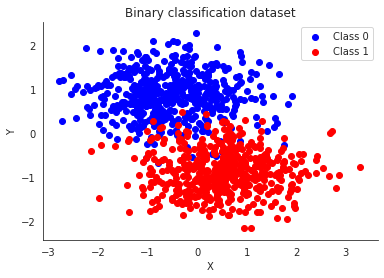

In [0]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], color='b', label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine()
ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Binary classification dataset')

## "Classic" neural networks model

I will implement an architecture with 2 hidden layer fully-connected layers, with 6 and with 3 neurons, using tanh as activation function and softmax for the output layer.

In [0]:
%%time

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(6, input_shape=(2,), activation='tanh'),
  tf.keras.layers.Dense(3, activation='tanh'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

CPU times: user 84 ms, sys: 900 µs, total: 84.9 ms
Wall time: 84.7 ms


In [0]:
model.fit(X_train, Y_train, epochs=5)
model.evaluate(X_test, Y_test)

Train on 700 samples
Epoch 1/5
700/700 [==============================] - 0s 41us/sample - loss: 0.4630 - acc: 0.9229
Epoch 2/5
700/700 [==============================] - 0s 39us/sample - loss: 0.4353 - acc: 0.9257
Epoch 3/5
700/700 [==============================] - 0s 43us/sample - loss: 0.4097 - acc: 0.9314
Epoch 4/5
700/700 [==============================] - 0s 42us/sample - loss: 0.3859 - acc: 0.9357
Epoch 5/5
300/300 [==============================] - 0s 30us/sample - loss: 0.3693 - acc: 0.9200


[0.3692865510781606, 0.92]

## Bayesian neural networks model

In [0]:
def construct_nn(ann_input, ann_output):
    init_1 = np.random.randn(X.shape[1], 6).astype('float64')
    init_2 = np.random.randn(6, 3).astype('float64')
    init_out = np.random.randn(3).astype('float64')

    with pm.Model() as neural_network:
        ann_input = pm.Data('ann_input', X_train)
        ann_output = pm.Data('ann_output', Y_train)

        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(X.shape[1], 6),
                                 testval=init_1)

        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(6, 3),
                                testval=init_2)

        weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                                  shape=(3,),
                                  testval=init_out)

        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out))

        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0]
                          )
    return neural_network

neural_network = construct_nn(X_train, Y_train)

In [0]:
set_tt_rng(MRG_RandomStreams(42))

In [0]:
%%time
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=50000, method=inference)

INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /root/.theano/compiledir_Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
Average Loss = 130.46: 100%|██████████| 50000/50000 [00:50<00:00, 980.52it/s]
Finished [100%]: Average Loss = 130.55
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 130.55


CPU times: user 51.3 s, sys: 6.04 s, total: 57.3 s
Wall time: 52.6 s


In [0]:
trace = approx.sample(draws=5000)

In [0]:
pm.set_data(new_data={'ann_input': X_test, 'ann_output': Y_test}, model=neural_network)
ppc = pm.sample_posterior_predictive(trace, samples=1000, progressbar=True, model=neural_network)
pred = ppc['out'].mean(axis=0) > 0.5

100%|██████████| 1000/1000 [00:11<00:00, 88.12it/s]


[Text(0, 0.5, 'Y'),
 Text(0.5, 0, 'X'),
 Text(0.5, 1.0, 'Predicted labels in testing set')]

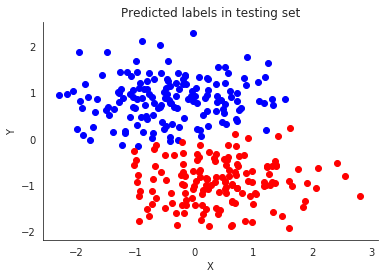

In [0]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1], color='b')
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y')

In [0]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 97.33333333333334%


As well, in this case "classic" neural network doesn't need so much time to train and predict as the Bayesian neural network, but the BNN has a signifiant better accuracy in my opinion, especially with regard to the distribution of the points in plane.

 ***L.E.: The Neural Networks in this project where designed only for comparison, I never aimed the state of the art for them.***